#Sentiment Analysis with BERT

##Installing Libraries

In [ ]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from tqdm.notebook import tqdm

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
synthetic_train_deep_learining=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ProcessedData/synthetic_train_deep_learining.csv')
synthetic_test_deep_learining=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ProcessedData/synthetic_test_deep_learining.csv')

In [ ]:
# This remove in final training round
# Get the first 20% of each DataFrame by sampling
# synthetic_train_deep_learining = synthetic_train_deep_learining.sample(frac=0.01, random_state=1).sort_index()
# synthetic_test_deep_learining = synthetic_test_deep_learining.sample(frac=0.01, random_state=1).sort_index()


In [ ]:
synthetic_train_deep_learining.head()

,sentence,sentiment,topic,sentiment_label
0,reporter country great idea,negative,facility,0
1,university musical artistic facility excellent,neutral,facility,1
2,classroom designed respond different student need,neutral,curriculum,1
3,program helped become expert field field,positive,curriculum,2
4,think program book record student realize many...,neutral,curriculum,1


##Tokenizing

In [ ]:
from transformers import BertTokenizer
from torch.utils.data import TensorDataset

In [ ]:
tokenizer = BertTokenizer.from_pretrained(
    'bert-base-uncased',
    do_lower_case=True
)

In [ ]:
# Ensure 'sentence' column is in string format
synthetic_train_deep_learining['sentence'] = synthetic_train_deep_learining['sentence'].astype(str)
synthetic_test_deep_learining['sentence'] = synthetic_test_deep_learining['sentence'].astype(str)

In [ ]:
synthetic_train_deep_learining['sentence'].values

array(['reporter country great idea',
       'university musical artistic facility excellent',
       'classroom designed respond different student need', ...,
       'heshe tra person also important person work',
       'program must respond personal need people worker',
       'switch thing meet personal need ai'], dtype=object)

In [ ]:
# Encode training data
encoded_data_train = tokenizer.batch_encode_plus(
    synthetic_train_deep_learining.sentence.values,
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    max_length=256,
    return_tensors='pt'
)

# Encode test data
encoded_data_test = tokenizer.batch_encode_plus(
    synthetic_test_deep_learining['sentence'].values,
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    max_length=256,
    return_tensors='pt'
)

# Extract input IDs and attention masks for training
input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(synthetic_train_deep_learining['sentiment_label'].values)

# Extract input IDs and attention masks for testing
input_ids_test = encoded_data_test['input_ids']
attention_masks_test = encoded_data_test['attention_mask']
labels_test = torch.tensor(synthetic_test_deep_learining['sentiment_label'].values)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
# Create TensorDataset for training data
dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)

# Create TensorDataset for testing data
dataset_test = TensorDataset(input_ids_test, attention_masks_test, labels_test)


In [ ]:
len(dataset_train),len(dataset_test)

(8144, 2036)

##Setting up BERT Pretrained Model

In [ ]:
from transformers import BertForSequenceClassification

In [ ]:
model=BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=len(synthetic_train_deep_learining['sentiment_label'].unique()),
    output_attentions=False,
    output_hidden_states=False
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
#List of labels that data set has ()
labels_of_sentimants=synthetic_train_deep_learining['sentiment_label'].unique().tolist()
labels_of_sentimants

[0, 1, 2]

In [ ]:
len(synthetic_train_deep_learining['sentiment_label'].unique())

3

## Creating Data Loaders

In [ ]:
from torch.utils.data import DataLoader,RandomSampler,SequentialSampler

In [ ]:
batch_size=16

dataloader_train=DataLoader(
    dataset_train,
    sampler=RandomSampler(dataset_train),
    batch_size=batch_size
)

dataloader_test=DataLoader(
    dataset_test,
    sampler=RandomSampler(dataset_test),
    batch_size=batch_size
)

## Setting Up optimizer and Schedular

In [ ]:
from transformers import AdamW,get_linear_schedule_with_warmup

In [ ]:
# optimizer=AdamW(
#     model.parameters(),
#     lr=1e-5,
#     eps=1e-8
# )

# Initialize the optimizer with model parameters
optimizer = AdamW(
    model.parameters(),
    lr=3e-5,  # Set learning rate to 0.00003
    eps=1e-8  # Small constant for numerical stability
)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
from transformers import get_linear_schedule_with_warmup

epochs=10

schedular=get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=len(dataloader_train)*epochs
)

## Defining Our Perfomance Metrics

In [ ]:
import numpy as np
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

In [ ]:
def accuracy_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return accuracy_score(labels_flat, preds_flat)

In [ ]:
def f1_score_func(preds,labels):
    preds_flat=np.argmax(preds,axis=1).flatten()
    labels_flat=labels.flatten()
    return f1_score(labels_flat,preds_flat,average='weighted')

In [ ]:
def classification_report_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    report = classification_report(labels_flat, preds_flat, output_dict=True)
    # Extract only the weighted average details
    final_report_details = report['weighted avg']
    return final_report_details

In [ ]:
# def accuracy_per_class(preds,labels):
#     label_dict_inverse={v:k for k,v in label_dict.items()}

#     preds_flat=np.argmax(preds,axis=1).flatten()
#     labels_flat=labels.flatten()
#     for label in np.unique(labels_flat):
#         y_preds=preds_flat[labels_flat==label]
#         y_true=labels_flat[labels_flat==label]
#         print(f'Class:{label_dict_inverse[label]}')
#         print(f'Accuracy:{len(y_preds[y_preds==label])}/{len(y_true)}\n')

## Creating Our Training Loop

In [ ]:
import random
seed_val=17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [ ]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(device)

cuda


In [ ]:
def evaluate(dataloader_val):
  model.eval()

  loss_val_total=0
  predictions,true_vals=[],[]

  for batch in dataloader_val:
    batch=tuple(b.to(device) for b in batch)
    inputs={'input_ids':batch[0],'attention_mask':batch[1],'labels':batch[2]}

    with torch.no_grad():
      outputs=model(**inputs)

    loss=outputs[0]
    logits=outputs[1]
    loss_val_total+=loss.item()

    logits=logits.detach().cpu().numpy()
    label_ids=inputs['labels'].cpu().numpy()
    predictions.append(logits)
    true_vals.append(label_ids)

  loss_val_avg=loss_val_total/len(dataloader_val)

  predictions=np.concatenate(predictions,axis=0)
  true_vals=np.concatenate(true_vals,axis=0)

  return loss_val_avg,predictions,true_vals

In [ ]:
# Initialize lists to store accuracy values
train_accuracies = []
test_accuracies = []

In [ ]:
for epoch in tqdm(range(1,epochs+1)):
  model.train()

  loss_train_total=0

  progress_bar=tqdm(dataloader_train,desc='Epoch {:1d}'.format(epoch),
                    leave=False,
                    disable=False)
  for batch in progress_bar:
    model.zero_grad()
    batch=tuple(b.to(device) for b in batch)

    inputs={'input_ids':batch[0],'attention_mask':batch[1],'labels':batch[2]}
    outputs=model(**inputs)

    loss=outputs[0]
    loss_train_total+=loss.item()
    loss.backward()

    torch.nn.utils.clip_grad_norm_(model.parameters(),1.0)
    optimizer.step()
    schedular.step()

    progress_bar.set_postfix({'training_loss':'{:.3f}'.format(loss.item()/len(batch))})

  #torch.save(model.state_dict(),f'BERT_ft_epoch{epoch}.model')
  #torch.save(model.state_dict(), f'/content/drive/MyDrive/Colab Notebooks/ProcessedData/BERT_ft_epoch{epoch}.model')
  tqdm.write('\nEpoch {epoch}')

  loss_train_avg=loss_train_total/len(dataloader_train)
  tqdm.write(f'Training loss:{loss_train_avg}')

  train_loss,train_prediction,_true_train_vals=evaluate(dataloader_train)
  test_loss,predictions,true_vals=evaluate(dataloader_test)

  train_accuracy = accuracy_func(train_prediction, _true_train_vals)
  test_accuracy = accuracy_func(predictions, true_vals)

  train_accuracies.append(train_accuracy)
  test_accuracies.append(test_accuracy)

  test_f1=f1_score_func(predictions,true_vals)
  test_class_report = classification_report_func(predictions, true_vals)
  tqdm.write(f'Test loss:{test_loss}')

  tqdm.write(f'Test Accuracy:{test_accuracy}')
  tqdm.write(f'Train Accuracy:{train_accuracy}')

  tqdm.write(f'F1 Score: {test_f1}')
  tqdm.write(f'Classification Report:\n{test_class_report}')

torch.save(model.state_dict(), f'/content/drive/MyDrive/Colab Notebooks/ProcessedData/BERT_ft_final.model')

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/509 [00:00<?, ?it/s]


Epoch {epoch}
Training loss:0.5984004981859729
Test loss:1.0332810904365033
Test Accuracy:0.581041257367387
Train Accuracy:0.81299115913556
F1 Score: 0.5760928640419357
Classification Report:
{'precision': 0.576958427065676, 'recall': 0.581041257367387, 'f1-score': 0.5760928640419357, 'support': 2036.0}


Epoch 2:   0%|          | 0/509 [00:00<?, ?it/s]


Epoch {epoch}
Training loss:0.472861298533753
Test loss:1.141351550933905
Test Accuracy:0.581041257367387
Train Accuracy:0.8953831041257367
F1 Score: 0.5827876601030196
Classification Report:
{'precision': 0.593189856519488, 'recall': 0.581041257367387, 'f1-score': 0.5827876601030196, 'support': 2036.0}


Epoch 3:   0%|          | 0/509 [00:00<?, ?it/s]


Epoch {epoch}
Training loss:0.4327283599697537
Test loss:1.2610557973384857
Test Accuracy:0.5555009823182712
Train Accuracy:0.925221021611002
F1 Score: 0.5542665709569865
Classification Report:
{'precision': 0.5820450370304757, 'recall': 0.5555009823182712, 'f1-score': 0.5542665709569865, 'support': 2036.0}


Epoch 4:   0%|          | 0/509 [00:00<?, ?it/s]


Epoch {epoch}
Training loss:0.28707275915642094
Test loss:1.5657124457648024
Test Accuracy:0.5800589390962672
Train Accuracy:0.9702848722986247
F1 Score: 0.5813793515681674
Classification Report:
{'precision': 0.5870490316633673, 'recall': 0.5800589390962672, 'f1-score': 0.5813793515681674, 'support': 2036.0}


Epoch 5:   0%|          | 0/509 [00:00<?, ?it/s]


Epoch {epoch}
Training loss:0.2035360880843812
Test loss:1.8765855068340898
Test Accuracy:0.5923379174852652
Train Accuracy:0.9830550098231827
F1 Score: 0.5929207923685195
Classification Report:
{'precision': 0.5976857189590027, 'recall': 0.5923379174852652, 'f1-score': 0.5929207923685195, 'support': 2036.0}


Epoch 6:   0%|          | 0/509 [00:00<?, ?it/s]


Epoch {epoch}
Training loss:0.1541093658568513
Test loss:2.307409250875935
Test Accuracy:0.5849705304518664
Train Accuracy:0.9852652259332023
F1 Score: 0.5821702528874884
Classification Report:
{'precision': 0.5820279928800542, 'recall': 0.5849705304518664, 'f1-score': 0.5821702528874884, 'support': 2036.0}


Epoch 7:   0%|          | 0/509 [00:00<?, ?it/s]


Epoch {epoch}
Training loss:0.11557786074279
Test loss:2.6753746839240193
Test Accuracy:0.581041257367387
Train Accuracy:0.9914047151277013
F1 Score: 0.5793841472057122
Classification Report:
{'precision': 0.5791186745640662, 'recall': 0.581041257367387, 'f1-score': 0.5793841472057122, 'support': 2036.0}


Epoch 8:   0%|          | 0/509 [00:00<?, ?it/s]


Epoch {epoch}
Training loss:0.07955213254327934
Test loss:2.920068783685565
Test Accuracy:0.5756385068762279
Train Accuracy:0.9952111984282908
F1 Score: 0.5744302190071224
Classification Report:
{'precision': 0.5748376027710109, 'recall': 0.5756385068762279, 'f1-score': 0.5744302190071224, 'support': 2036.0}


Epoch 9:   0%|          | 0/509 [00:00<?, ?it/s]


Epoch {epoch}
Training loss:0.0551741334251693
Test loss:3.035484868567437
Test Accuracy:0.5839882121807466
Train Accuracy:0.9960707269155207
F1 Score: 0.5844553470056194
Classification Report:
{'precision': 0.5857431980385137, 'recall': 0.5839882121807466, 'f1-score': 0.5844553470056194, 'support': 2036.0}


Epoch 10:   0%|          | 0/509 [00:00<?, ?it/s]


Epoch {epoch}
Training loss:0.0482003190110116
Test loss:3.1275715520605445
Test Accuracy:0.5820235756385069
Train Accuracy:0.9963163064833006
F1 Score: 0.5826723612342324
Classification Report:
{'precision': 0.5835576188201166, 'recall': 0.5820235756385069, 'f1-score': 0.5826723612342324, 'support': 2036.0}


In [ ]:
# for epoch in tqdm(range(1,epochs+1)):
#   model.train()

#   loss_train_total=0

#   progress_bar=tqdm(dataloader_train,desc='Epoch {:1d}'.format(epoch),
#                     leave=False,
#                     disable=False)
#   for batch in progress_bar:
#     model.zero_grad()
#     batch=tuple(b.to(device) for b in batch)

#     inputs={'input_ids':batch[0],'attention_mask':batch[1],'labels':batch[2]}
#     outputs=model(**inputs)

#     loss=outputs[0]
#     loss_train_total+=loss.item()
#     loss.backward()

#     torch.nn.utils.clip_grad_norm_(model.parameters(),1.0)
#     optimizer.step()
#     schedular.step()

#     progress_bar.set_postfix({'training_loss':'{:.3f}'.format(loss.item()/len(batch))})

#   #torch.save(model.state_dict(),f'BERT_ft_epoch{epoch}.model')
#   #torch.save(model.state_dict(), f'/content/drive/MyDrive/Colab Notebooks/ProcessedData/BERT_ft_epoch{epoch}.model')
#   tqdm.write('\nEpoch {epoch}')

#   loss_train_avg=loss_train_total/len(dataloader_train)
#   tqdm.write(f'Training loss:{loss_train_avg}')

#   val_loss,predictions,true_vals=evaluate(dataloader_test)
#   val_f1=f1_score_func(predictions,true_vals)
#   val_accuracy = accuracy_func(predictions, true_vals)
#   val_class_report = classification_report_func(predictions, true_vals)


#   tqdm.write(f'Validation loss:{val_loss}')
#   tqdm.write(f'F1 Score: {val_f1}')
#   tqdm.write(f'Accuracy:{val_accuracy}')
#   tqdm.write(f'Classification Report:\n{val_class_report}')

# torch.save(model.state_dict(), f'/content/drive/MyDrive/Colab Notebooks/ProcessedData/BERT_ft_epoch{epoch}.model')

In [ ]:
!ls

drive  sample_data


## Loading and Evaluation our Model

In [ ]:
model_1=BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=len(synthetic_train_deep_learining['sentiment_label'].unique()),
    output_attentions=False,
    output_hidden_states=False
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


##Accuracy Graph

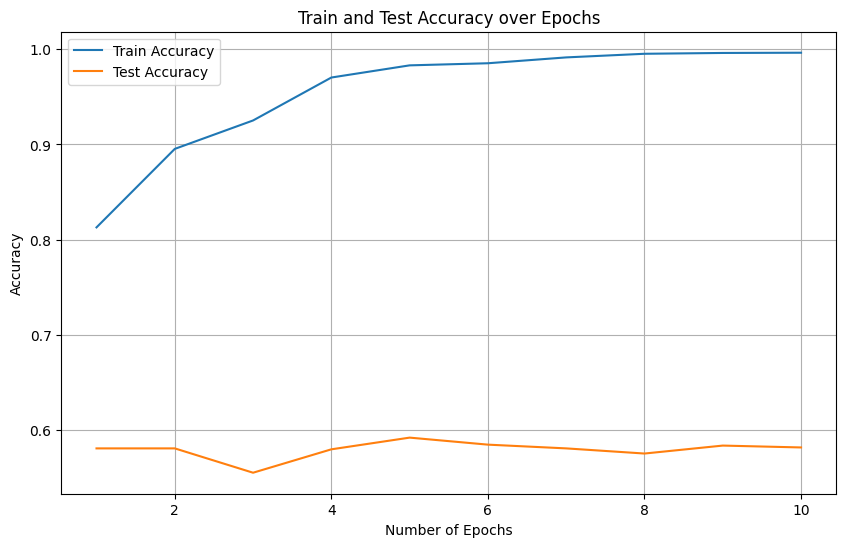

In [ ]:
# Plotting Accuracy over Epochs
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, epochs + 1), test_accuracies, label='Test Accuracy')

plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.title('Train and Test Accuracy over Epochs')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# model.load_state_dict(torch.load('BERT_ft_epoch10.model',map_location=torch.device('cpu')))

In [ ]:
train_accuracy

0.9963163064833006